In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
# Algorithms
import cma
from es import CMAES, OpenES
# Run the fitness 
from oct2py import Oct2Py
from multiprocessing.pool import ThreadPool 
# Run multiple Zs as different processes
from multiprocessing import Pool
# to save the progress of the algorithms
import csv
from datetime import datetime
from os import mkdir

In [2]:
# -------- range of the variables ----------
V_S = 7.0                   # service speed [kn]
range_D     = [0.5, 0.8]
range_AEdAO = [0.3, 1.05]
range_PdD   = [0.5, 1.4]
range_Z     = [2, 7]

# Define the lower and upper bounds for each variable
lower_bounds = [range_D[0], range_AEdAO[0], range_PdD[0]]
upper_bounds = [range_D[1], range_AEdAO[1], range_PdD[1]]

In [3]:
# OPENAI-ES and CMAES
NPOPULATION   = 12 # size of population
MAX_ITERATION = 30 # run solver for this generations

NPARAMS = 3  # number of parameters to evaluate
SIGMA_INIT_CMAES    = 0.1
SIGMA_INIT_OPENAIES = 0.1

# seed for generating the random first element
SEED = 0

In [4]:
random.seed(SEED)
x0 =  [
        random.uniform(range_D[0],     range_D[1]),
        random.uniform(range_AEdAO[0], range_AEdAO[1]),
        random.uniform(range_PdD[0],   range_PdD[1])
      ]

print("D    ", x0[0])
print("AEdAO", x0[1])
print("PdD  ", x0[2])

D     0.7533265554575145
AEdAO 0.868465802205227
PdD   0.8785144227477605


In [5]:
save_file = True
save_in_same_dir = True

if save_file:    
    if save_in_same_dir:
        # create main_date dir
        now = datetime.now()
        main_dir_name = 'main_' + now.strftime("%Y_%m_%d_%H_%M")
        try:
            mkdir(main_dir_name)
        except: pass
        # save the configs in a file
        filename = main_dir_name+'/' + 'configs.csv'
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow( ["NPOPULATION",    NPOPULATION] )
            writer.writerow( ["MAX_ITERATION",  MAX_ITERATION] )
            writer.writerow( ["SEED",           SEED] )
            writer.writerow( ["x0 D",           x0[0]] )
            writer.writerow( ["x0 AEdAO",       x0[1]] )
            writer.writerow( ["x0 PdD",         x0[2]] )
            writer.writerow( ["SIGMA_INIT_CMAES",    SIGMA_INIT_CMAES] )
            writer.writerow( ["SIGMA_INIT_OPENAIES", SIGMA_INIT_OPENAIES] )

In [6]:
# -- functions to save a file and create a dir --
def append_to_file(filename, row):
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)
    
def append_to_file_order(filename, D='', AEdAO='', PdD='', Z='', P_B='', n='', fitness='', i=''):
    row = [D, AEdAO, PdD, Z, P_B, n, fitness, i]
    append_to_file(filename, row)
    
def create_file(text):
    filename = dir_name+'/' + text +'.csv'
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        header = ["D = propeller diameter [m]", 
                  "AEdAO = expanded area ratio", 
                  "PdD = pitch ratio", 
                  "Z = propeller's number of blades", 
                  "P_B = power brake", 
                  "n = Propeller angular speed [rpm]", 
                  "fitness", 
                  "i = thread pool id"]
        writer.writerow(header) 
    return filename

def create_dir(text):
    if save_in_same_dir:
        dir_name = './' + main_dir_name + '/' + text
    else:
        now = datetime.now()
        dir_name = './' + text +'_'+ now.strftime("%Y_%m_%d_%H_%M")
    try:
        mkdir(dir_name)
    except: pass
    return dir_name

Fitness and Evaluation

In [7]:
# run the Octave script to get the power brake for the params
def run_octave_evaluation(V_S,D,Z,AEdAO,PdD):
    P_B, n = [0, 0]
    with Oct2Py() as octave:
        octave.warning ("off", "Octave:data-file-in-path");
        octave.addpath('./allCodesOctave');
        P_B, n = octave.F_LabH2(V_S,D,Z,AEdAO,PdD, nout=2)
#         P_B, n = octave.F_LabH2_no_cav_lim(V_S,D,Z,AEdAO,PdD, nout=2)
#         P_B, n = octave.F_LabH2_aprox_no_cav_lim(V_S,D,Z,AEdAO,PdD, nout=2)
#         P_B, n = octave.F_LabH2_aprox(V_S,D,Z,AEdAO,PdD, nout=2)
    return [P_B, n]

In [8]:
# fitness function, to find the minimal power brake
def evaluate_solution(x, i=None):
    D     = x[0]
    AEdAO = x[1]
    PdD   = x[2]
    # verify that the values are in range
    penalty = -1000
    if (D > range_D[1] or D < range_D[0]):
        print("out","_D_:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD)
        return penalty
    if (AEdAO > range_AEdAO[1] or AEdAO < range_AEdAO[0]):
        print("out","D:",D,"Z:",Z,"_AEdAO_:",AEdAO,"PdD:",PdD)
        return penalty
    if (PdD > range_PdD[1] or PdD < range_PdD[0]):
        print("out","D:",D,"Z:",Z,"AEdAO:",AEdAO,"_PdD_:",PdD)
        return penalty

    P_B, n = run_octave_evaluation(V_S,D,Z,AEdAO,PdD)
    # to get the minimal P_B 
    # the solvers use the max value as best fitness
    fit_value = 0
    if (P_B == 0 or n == 0):
        fit_value = penalty
    else:
        fit_value = -P_B
    
#     print("D:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD, "fitness:",fit_value)
    if save_file:
        append_to_file(filename, [D, AEdAO, PdD, Z, P_B, n, fit_value, i])

    return fit_value

# use evaluate_solution as the fitness function
fit_func = evaluate_solution

Run logic for each iteration of the solver

In [9]:
# wrapper tho add the index of solution in the array, to the response of the ThreadPool
def fit_func_parallel_wrapper(i, solution):
    fitness = fit_func(solution, i)
    return [i, fitness]

# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = np.zeros(MAX_ITERATION)
    for j in range(MAX_ITERATION):
        # ask for the population 
        solutions = solver.ask()
        # create a list with the fitness
        fitness_list = np.zeros(solver.popsize)
        # parallel run of fitness evaluation
        with ThreadPool() as pool:
            id_solutions = [(i, solutions[i]) for i in range(len(solutions))]
            for result in pool.starmap(fit_func_parallel_wrapper, id_solutions):
                i, fitness = result
                fitness_list[i] = fitness
        # pass the fitness to the solver so it can decide the best individual
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history[j] = result[1]   # best fitness
        # print the process name (Z) and the iteration, and save in the csv
        print('Z:',Z, "fitness at iteration", (j+1), result[1], flush=True)
        if save_file:
            append_to_file_order(filename, "fitness at iteration", j, fitness=result[1])
    # best solution at the end of the solver's run
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return (history, result[0])

solvers definition

In [10]:
# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
              x0=x0,                     # initial parameters values to generate the population
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = SIGMA_INIT_CMAES,
              lower_bounds=lower_bounds,
              upper_bounds=upper_bounds,
          )

(2_w,5mirr1)-aCMA-ES (mu_w=1.6,w_1=73%) in dimension 3 (seed=456030, Tue Jun 20 21:52:58 2023)


In [12]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
openaies = OpenES(NPARAMS,                 # number of model parameters
                x0=x0,                     # initial parameters values to generate the population
                sigma_init=SIGMA_INIT_OPENAIES, # initial standard deviation
                sigma_decay=0.999,         # don't anneal standard deviation
                learning_rate=0.1,         # learning rate for standard deviation
                learning_rate_decay = 1.0, # annealing the learning rate
                popsize=NPOPULATION,       # population size
                antithetic=False,          # whether to use antithetic sampling
                weight_decay=0.00,         # weight decay coefficient
                rank_fitness=False,        # use rank rather than fitness numbers
                forget_best=False,
                lower_bounds=lower_bounds, # list of lower bounds for the parameters
                upper_bounds=upper_bounds) # list of upper bounds for the parameters

## Parallel Run

In [13]:
# run the especified solver for the z passed
def solver_for_Z(solver, z):
    global Z
    Z = z
    
    # create the csv file with the headers
    if save_file:
        global filename
        filename = create_file(str(Z))
        
    # run the solver
    history, best_solution = test_solver(solver)

    # get the P_B from best solution
    D       = best_solution[0]
    AEdAO   = best_solution[1]
    PdD     = best_solution[2]
    fitness = history[-1]
    print("Z:",Z, "Best Solution:", best_solution, 'with fitness:', fitness)
    
    if save_file:
        # write best solution to the end of file
        append_to_file(filename, ["Best Solution"])
        append_to_file_order(filename, D=D, AEdAO=AEdAO, PdD=PdD, Z=Z, fitness=fitness)

    return [Z, best_solution, fitness, history]

In [14]:
# results[0] = [Z, (D, AEdAO, PdD), fitness, history]
def get_best_result(results):
    # get result with best fitness
    best_result = max(results, key=(lambda x: x[2]))
    
    Z             =  best_result[0]
    D, AEdAO, PdD =  best_result[1]
    P_B           = -best_result[2]
    print("D:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD)
    print("P_B:",P_B)
    
    return best_result

CMAES parallel

In [15]:
if save_file:
    global dir_name
    dir_name = create_dir('cmaes')

solver = cmaes
results_cmaes = []
# create a new process for to run each Z
with Pool() as pool:
    solver_zs = [(solver, z) for z in range(range_Z[0],range_Z[1]+1)]
    for result in pool.starmap(solver_for_Z, solver_zs):
        results_cmaes.append(result)

Z: 2 fitness at iteration 1 -93.76010346980165
Z: 5 fitness at iteration 1 -85.49433126651925
Z: 4 fitness at iteration 1 -87.0383273379174
Z: 3 fitness at iteration 1 -89.84642064481909
Z:5  fitness at iteration 2 -85.16296038849637
local optimum discovered by solver:
Z:  [0.79914148 0.9789871  0.88201138]2
 fitness at iteration 2 -93.64450892511064fitness score at this local optimum: 
local optimum discovered by solver:
-85.16296038849637 [0.78718877 1.03981979 0.92039276]
fitness score at this local optimum: -93.64450892511064
Z: Z:5
 Best Solution:Z:  4[0.79914148 0.9789871  0.88201138] fitness at iteration with fitness:   2-85.16296038849637
2 -86.80400187580376
 local optimum discovered by solver:
 [0.79914148 0.9789871  0.88201138]Best Solution: [0.78718877 1.03981979 0.92039276]Z:
  fitness score at this local optimum: with fitness:3-86.80400187580376 fitness at iteration 
 Z:-93.64450892511064
2  -89.656430563211434
 Best Solution:local optimum discovered by solver:
  [0.79914

In [16]:
# sort by Z
results_cmaes.sort(key=(lambda r: r[0]))

print("Best result cmaes")
best_result_cmaes = get_best_result(results_cmaes)

Best result cmaes
D: 0.7991414813953522 Z: 6 AEdAO: 0.9789870982792837 PdD: 0.8820113751869312
P_B: 84.74022924947245


OPENAI-ES parallel

In [17]:
if save_file:
    global dir_name
    dir_name = create_dir('openaies')

solver = openaies
results_openaies = []
# create a new process for to run each Z
with Pool() as pool:
    solver_zs = [(solver, z) for z in range(range_Z[0],range_Z[1]+1)]
    for result in pool.starmap(solver_for_Z, solver_zs):
        results_openaies.append(result)

Z:Z:  54 fitness at iteration fitness at iteration  1 1-85.54104487203003
 -87.08498553105684
Z: 2 fitness at iterationZ:  1 3-93.71356577956007 
fitness at iteration 1 -89.8035751359264
Z: 2Z:  fitness at iteration3  2fitness at iteration  -93.460010857755852
 local optimum discovered by solver:
-89.1159209717085
 local optimum discovered by solver:
[0.8        1.01788724 0.84958047]
 fitness score at this local optimum:[0.8        0.93013888 0.79493965] 
fitness score at this local optimum:-93.46001085775585 -89.1159209717085

Z: Z:2  3Best Solution: Best Solution: [0.8        1.01788724 0.84958047]  with fitness:[0.8        0.93013888 0.79493965]  with fitness:-93.46001085775585
 -89.1159209717085
Z:Z:  54  fitness at iterationfitness at iteration  2 2 -83.79642651720255
-85.62581817882787local optimum discovered by solver:
 
[0.8        0.92205501 0.6795591 ]local optimum discovered by solver:
 
[0.8        0.93013888 0.79493965]
fitness score at this local optimum:fitness score at

In [18]:
# sort by Z
results_openaies.sort(key=(lambda r: r[0]))

print("Best result openai-es")
best_result_openaies = get_best_result(results_openaies)

Best result openai-es
D: 0.8 Z: 5 AEdAO: 0.9220550067391989 PdD: 0.6795590952792311
P_B: 83.79642651720255


## Save the best result

In [25]:
def save_best_result(result, solver_name, seed=None):
    # in case there is main dir, save the best results in this same dir,
    #     otherwise will save in the last dir created (openaies)
    if save_in_same_dir
        global dir_name, main_dir_name
        dir_name = main_dir_name
    # create the csv file with the headers
    global filename
    if seed:
        filename = create_file('best_results_' + solver_name)
    else:
        filename = create_file('best_results_' + str(seed) + '_' + solver_name)
    #
    Z             = result[0]
    D, AEdAO, PdD = result[1]
    fitness       = result[2]
    append_to_file_order(filename, D=D, AEdAO=AEdAO, PdD=PdD, Z=Z, fitness=fitness)
    # if there is history to save
    if (len(result) > 2):
        history   = result[3]
        append_to_file(filename, ['history'])
        append_to_file(filename, history)
    
# ======== SAVE ============
save_best_result(best_result_cmaes, 'cmaes')
save_best_result(best_result_openaies, 'openaies')
print('saved')

saved


## Analise

In [26]:
# creates a figure for a list of tuples (label, history)
def create_history_fig(labels, histories):
    # Create a new figure
    plt.figure(figsize=(16,8), dpi=150)

    lines = []
    for i in  range(len(histories)):
        label_h = labels[i]
        history = histories[i]
        history = np.negative(history)
        line, = plt.plot(history, linewidth=1.0, label=label_h)
        lines.append(line)
        
    plt.legend(handles=lines, loc=4)

    # Set x limits
    # plt.xlim(0,50)

    plt.xlabel('generation')
    plt.ylabel('fitness')

    # plt.savefig("./output_image.svg")

    plt.show()

CMA-ES


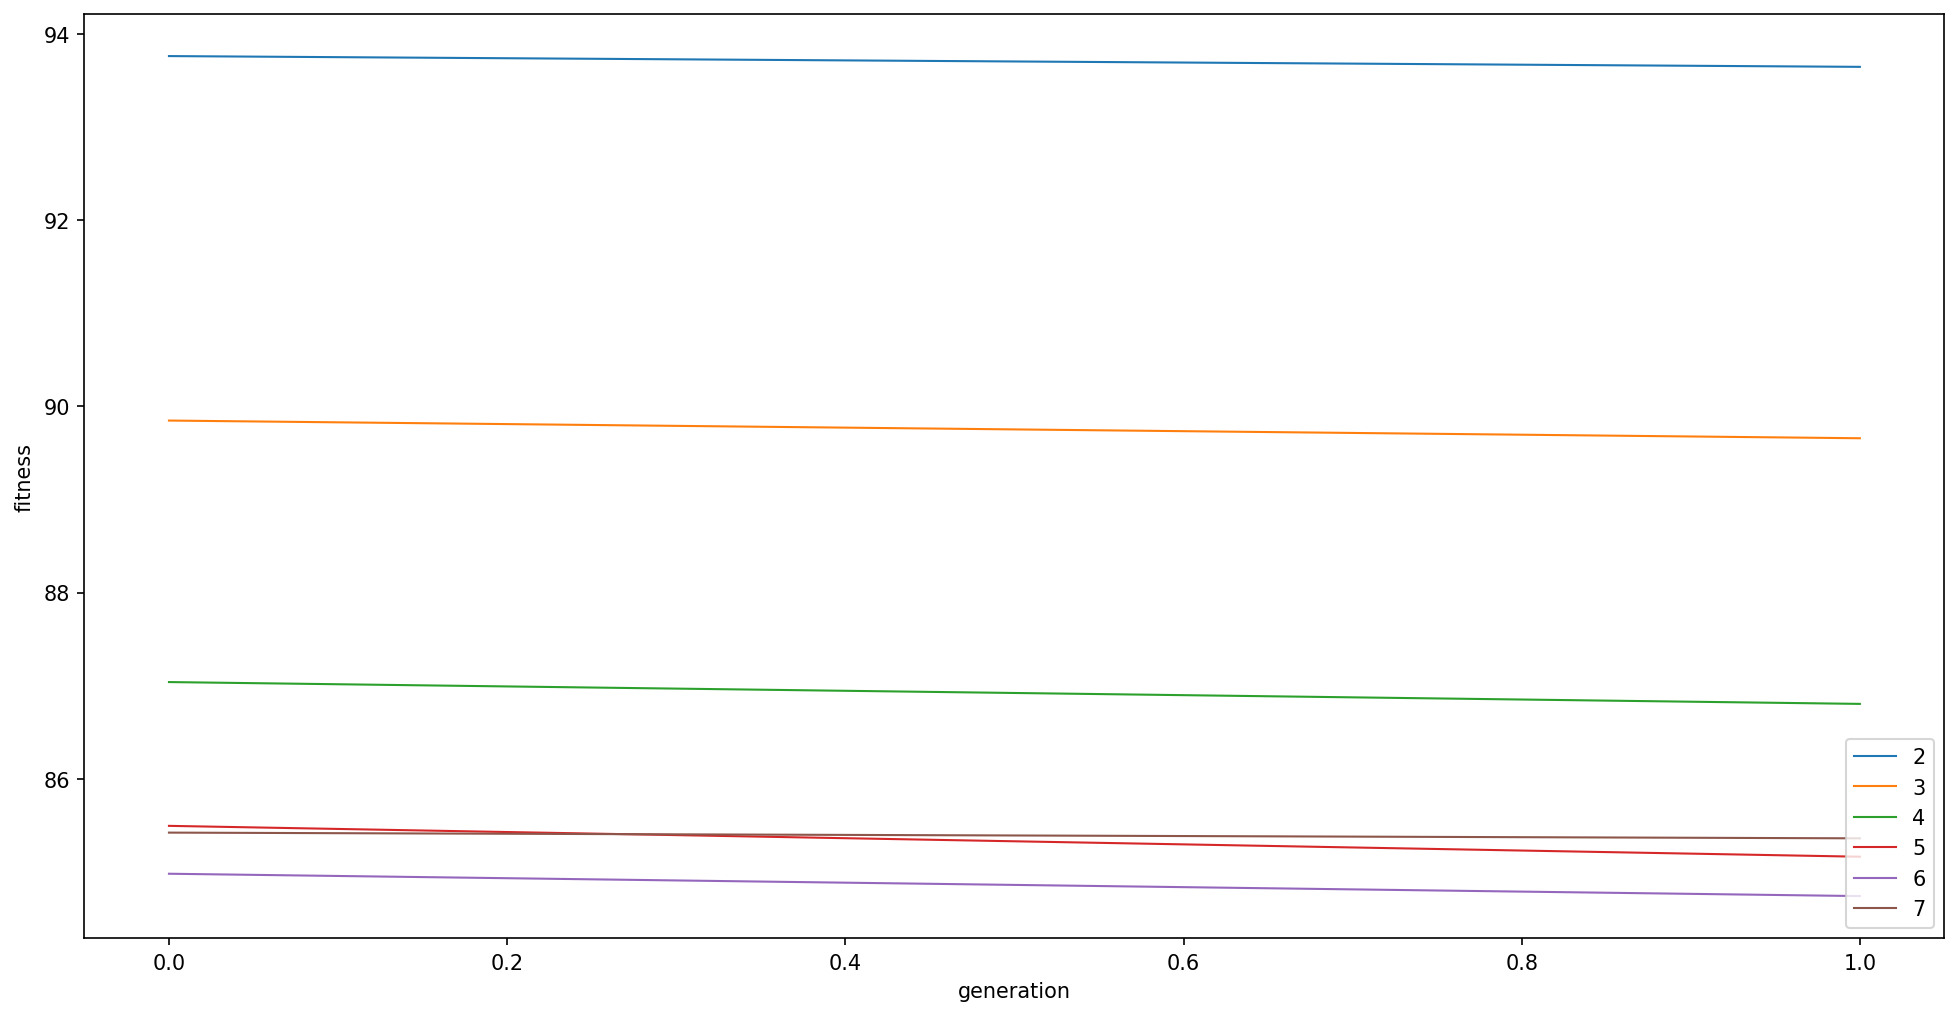

In [28]:
print("CMA-ES")
# Label each Z
labels          = [str(r[0])     for r in results_cmaes]
fitnesses_cmaes = np.array([r[3] for r in results_cmaes])
# create image with Z's as labels
create_history_fig(labels, fitnesses_cmaes)

OPENAI-ES


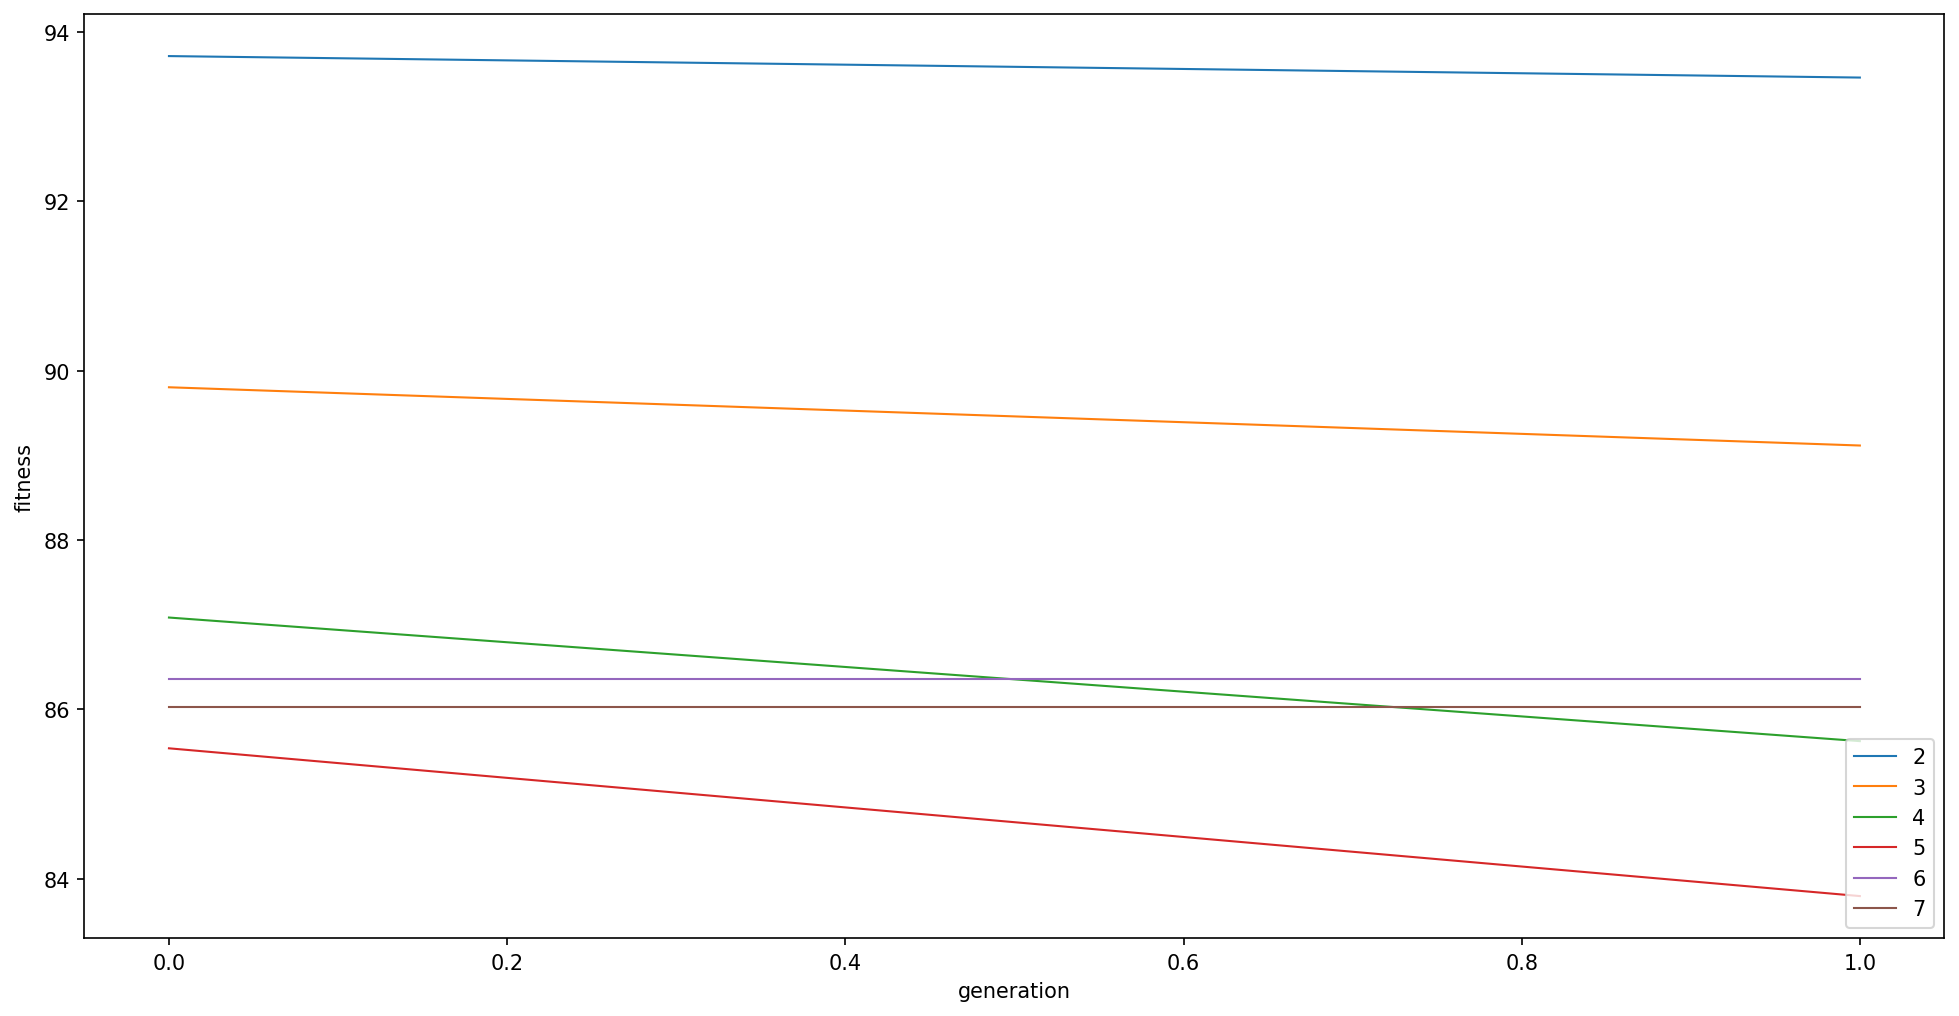

In [29]:
print("OPENAI-ES")
# Label each Z
labels             = [str(r[0])     for r in results_openaies]
fitnesses_openaies = np.array([r[3] for r in results_openaies])
# create image with Z's as labels
create_history_fig(labels, fitnesses_openaies)

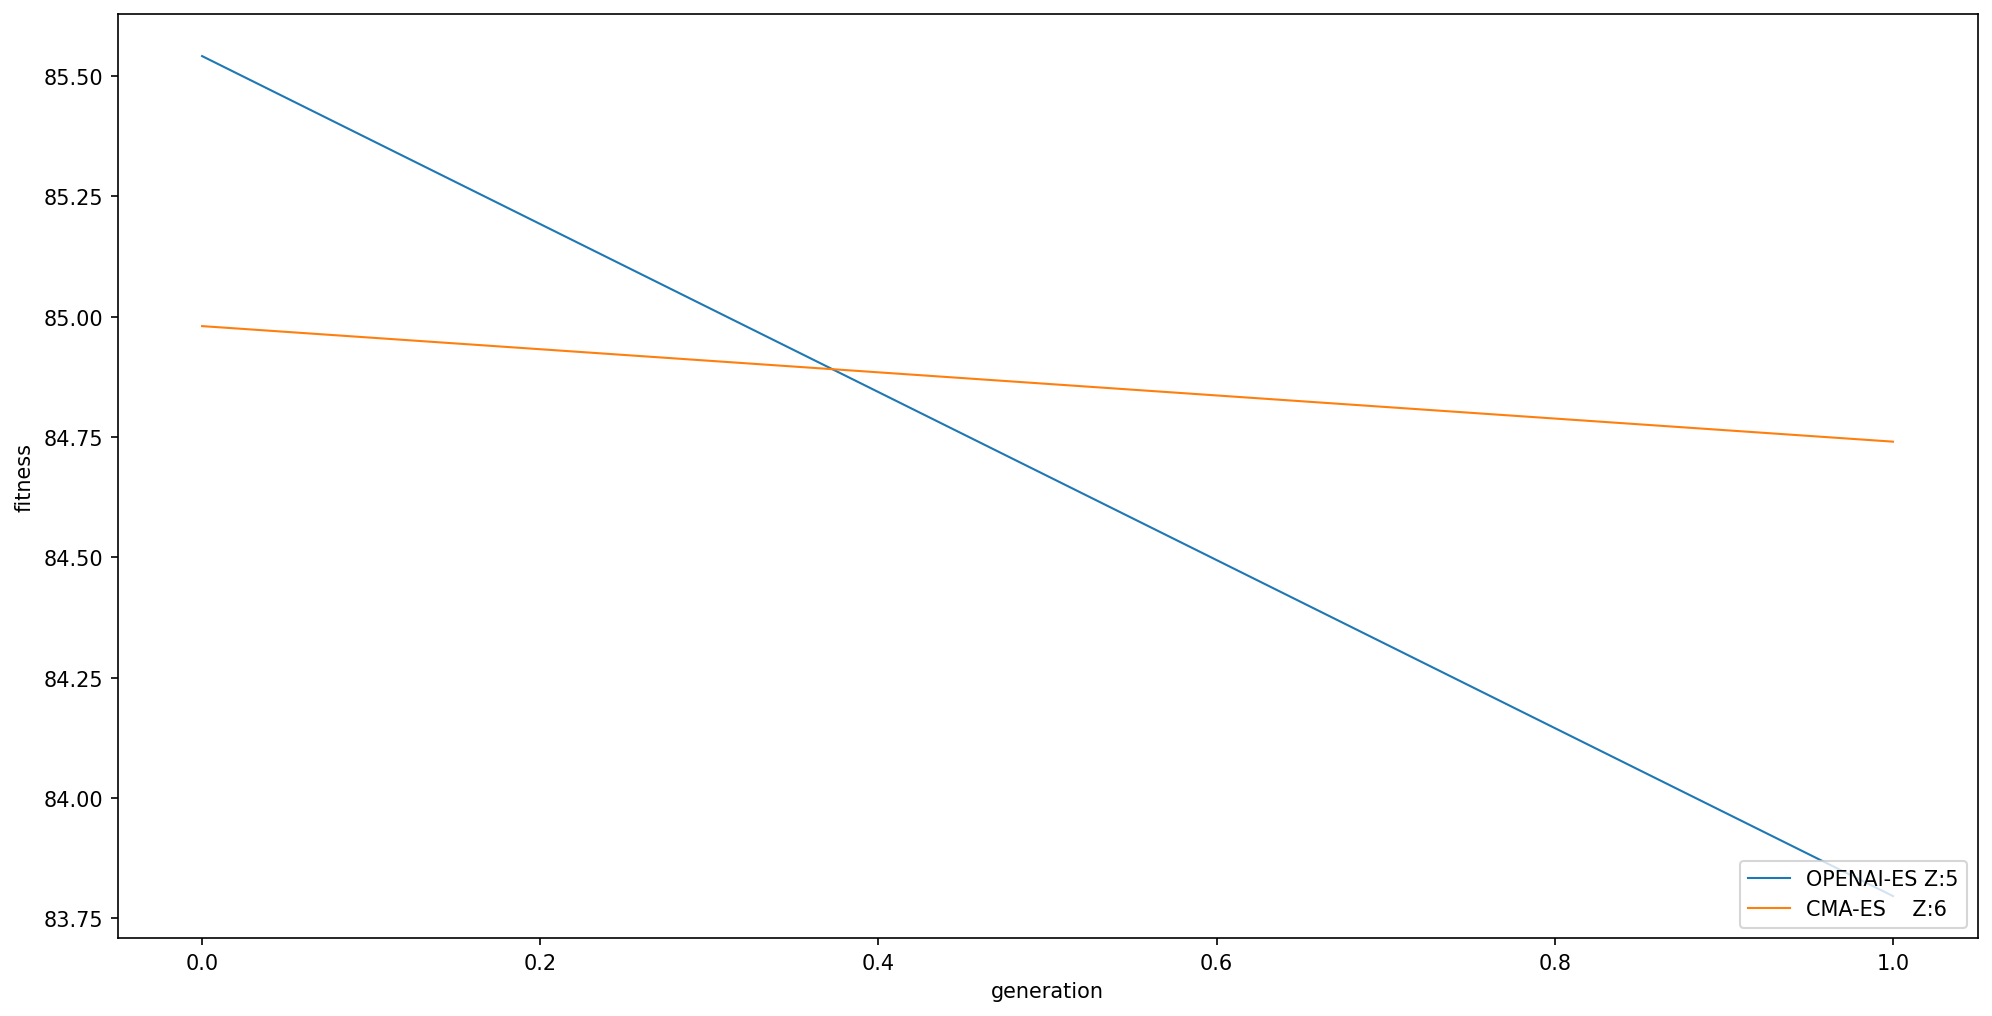

In [35]:
best_result_openaies = min(results_openaies, key=lambda r: -r[2])
best_result_cmaes    = min(results_cmaes,    key=lambda r: -r[2])

labels    = ['OPENAI-ES Z:'+str(best_result_openaies[0]),
             'CMA-ES    Z:'+str(best_result_cmaes[0])]
fitnesses = [np.array(best_result_openaies[3]), 
             np.array(best_result_cmaes[3])]
# create image with Z's as labels
create_history_fig(labels, fitnesses)